# Setup

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import random

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_seed(42)

print("CUDA dostępna:", torch.cuda.is_available())
print("Nazwa GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Brak")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA dostępna: True
Nazwa GPU: NVIDIA GeForce RTX 4080 SUPER


# Load and Preprocess Data

In [15]:
# Define dataset parameters
SAMPLE_RATE = 16000
NUM_SAMPLES = 16000  # 1 second of audio
N_MELS = 128
N_FFT = 1024
HOP_LENGTH = 512

class SpeechCommandsDataset(Dataset):
    def __init__(self, root_dir, classes, transform=None):
        self.classes = classes
        self.filepaths = []
        self.labels = []
        
        for label, cls in enumerate(classes):
            cls_dir = os.path.join(root_dir, cls)
            for file in os.listdir(cls_dir):
                if file.endswith(".wav"):
                    self.filepaths.append(os.path.join(cls_dir, file))
                    self.labels.append(label)
        
        self.transform = transform
        self.resampler = T.Resample(orig_freq=16000, new_freq=SAMPLE_RATE)  # In case of varying sample rates

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        waveform, sample_rate = torchaudio.load(self.filepaths[idx])
        waveform = self.resampler(waveform)  # Ensure consistent sample rate
        
        # Pad or truncate to fixed length
        if waveform.shape[1] < NUM_SAMPLES:
            padding = (0, NUM_SAMPLES - waveform.shape[1])
            waveform = torch.nn.functional.pad(waveform, padding)
        else:
            waveform = waveform[:, :NUM_SAMPLES]
        
        if self.transform:
            waveform = self.transform(waveform)
        
        return waveform, self.labels[idx]

# Data transforms
mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)

# Initialize dataset (update path to your dataset location)
classes = ['yes', 'no']
# classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 
#            'zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine',
#            'bed', 'bird', 'cat', 'dog', 'happy', 'house', 'marvin', 'sheila', 'tree', 'wow', '_background_noise_']

dataset = SpeechCommandsDataset(
    root_dir="./data/train/audio/",
    classes=classes,
    transform=mel_spectrogram
)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Model

In [8]:
class AudioTransformer(nn.Module):
    def __init__(self, num_classes, d_model=256, nhead=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)  # Input: [B, 1, 128, 32]
        self.fc_in = nn.Linear(32, d_model)  # Corrected input dimension
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, num_classes)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        
    def forward(self, x):
        # Input shape: [B, 1, 128, 32] (no unsqueeze needed)
        x = self.conv(x)  # Output: [B, 32, 64, 16]
        B, C, H, W = x.shape
        x = x.permute(0, 2, 3, 1).reshape(B, H*W, C)  # [B, 1024, 32]
        x = self.fc_in(x)  # [B, 1024, d_model]
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = self.transformer_encoder(x)
        return self.fc_out(x[:, 0, :])

In [9]:

model = AudioTransformer(len(train_dataset.dataset.classes)).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Train

In [10]:
# Training loop
def train(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        output = model(data)  # Add channel dim
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"Train Epoch: {epoch}\tLoss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    
    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"Validation: Average loss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return acc

# Train for 10 epochs
best_val_acc = 0
for epoch in range(1, 11):
    train(model, train_loader, optimizer, criterion, epoch)
    val_acc = evaluate(model, val_loader, criterion)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")

Train Epoch: 1	Loss: 0.6460	Accuracy: 64.43%
Validation: Average loss: 0.5851	Accuracy: 70.95%
Train Epoch: 2	Loss: 0.5379	Accuracy: 72.77%
Validation: Average loss: 0.5036	Accuracy: 74.11%
Train Epoch: 3	Loss: 0.4901	Accuracy: 75.85%
Validation: Average loss: 0.4693	Accuracy: 77.26%
Train Epoch: 4	Loss: 0.5005	Accuracy: 75.69%
Validation: Average loss: 0.4970	Accuracy: 77.05%
Train Epoch: 5	Loss: 0.4701	Accuracy: 78.14%
Validation: Average loss: 0.4385	Accuracy: 79.16%
Train Epoch: 6	Loss: 0.4364	Accuracy: 79.85%
Validation: Average loss: 0.4748	Accuracy: 76.42%
Train Epoch: 7	Loss: 0.4285	Accuracy: 80.06%
Validation: Average loss: 0.5129	Accuracy: 74.95%
Train Epoch: 8	Loss: 0.4100	Accuracy: 81.27%
Validation: Average loss: 0.4170	Accuracy: 80.63%
Train Epoch: 9	Loss: 0.4072	Accuracy: 80.95%
Validation: Average loss: 0.4502	Accuracy: 79.37%
Train Epoch: 10	Loss: 0.3859	Accuracy: 81.95%
Validation: Average loss: 0.4203	Accuracy: 80.00%


# Verify

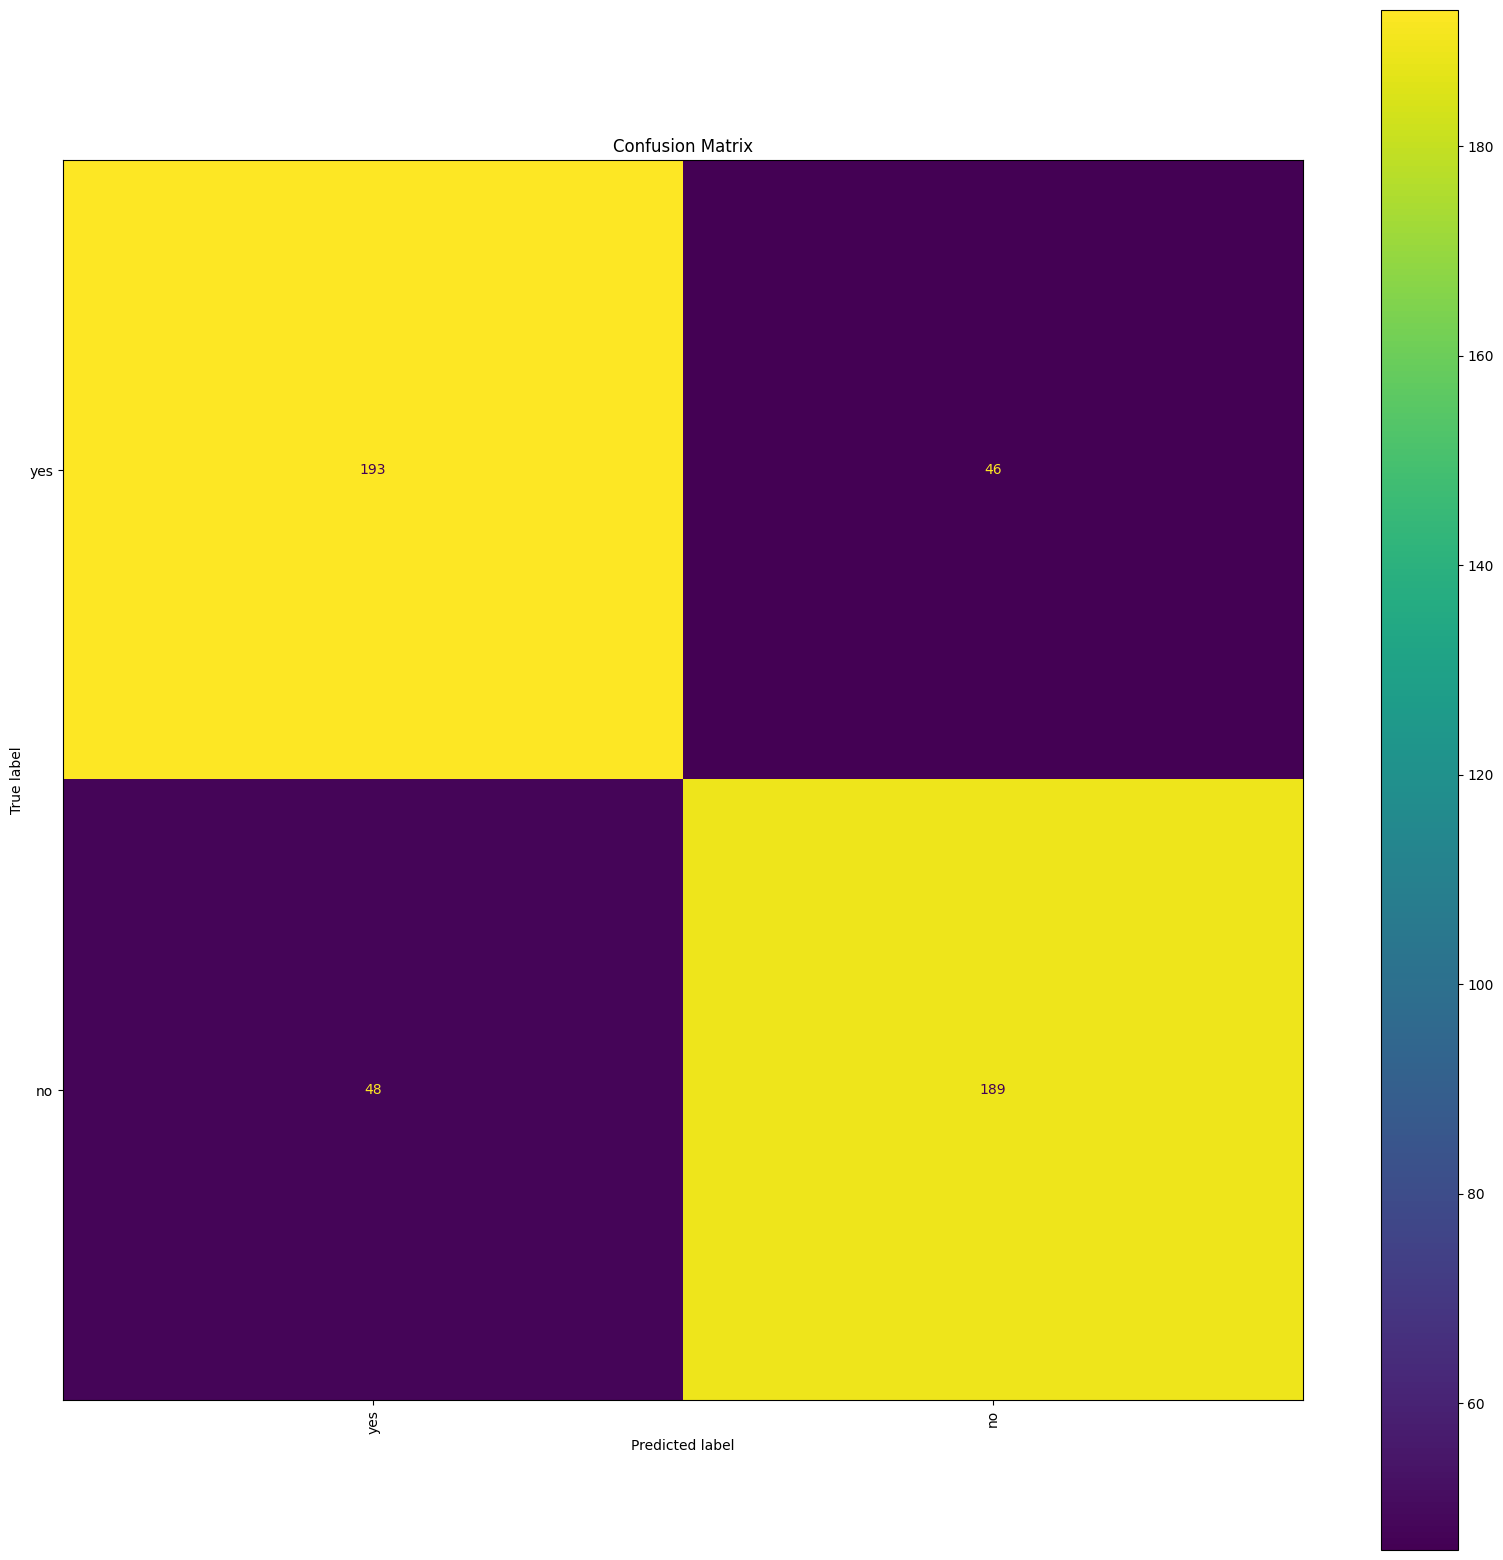

Test Accuracy: 80.25%


In [12]:
# Test evaluation
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.show()

# Calculate test accuracy
test_acc = 100. * np.sum(np.array(y_pred) == np.array(y_true)) / len(y_true)
print(f"Test Accuracy: {test_acc:.2f}%")

Training CNN Model:
Epoch 1 | Batch 0 | Loss: 6.0934
Epoch 1 | Batch 50 | Loss: 1.6564
CNN Train Epoch: 1	Loss: 6.3665	Accuracy: 60.69%
CNN Validation: Loss: 4.6566	Accuracy: 69.89%
Epoch 2 | Batch 0 | Loss: 1.0312
Epoch 2 | Batch 50 | Loss: 1.1529
CNN Train Epoch: 2	Loss: 2.8760	Accuracy: 72.59%
CNN Validation: Loss: 2.8697	Accuracy: 75.79%
Epoch 3 | Batch 0 | Loss: 1.5066
Epoch 3 | Batch 50 | Loss: 0.5262
CNN Train Epoch: 3	Loss: 1.9324	Accuracy: 75.72%
CNN Validation: Loss: 2.1312	Accuracy: 78.53%
Epoch 4 | Batch 0 | Loss: 0.8593
Epoch 4 | Batch 50 | Loss: 0.5983
CNN Train Epoch: 4	Loss: 1.4549	Accuracy: 77.37%
CNN Validation: Loss: 2.4186	Accuracy: 77.47%
Epoch 5 | Batch 0 | Loss: 1.7177
Epoch 5 | Batch 50 | Loss: 0.3864
CNN Train Epoch: 5	Loss: 1.1451	Accuracy: 79.03%
CNN Validation: Loss: 1.9337	Accuracy: 78.95%
Epoch 6 | Batch 0 | Loss: 0.7917
Epoch 6 | Batch 50 | Loss: 0.8487
CNN Train Epoch: 6	Loss: 0.9170	Accuracy: 80.87%
CNN Validation: Loss: 1.6962	Accuracy: 80.84%
Epoch 7 

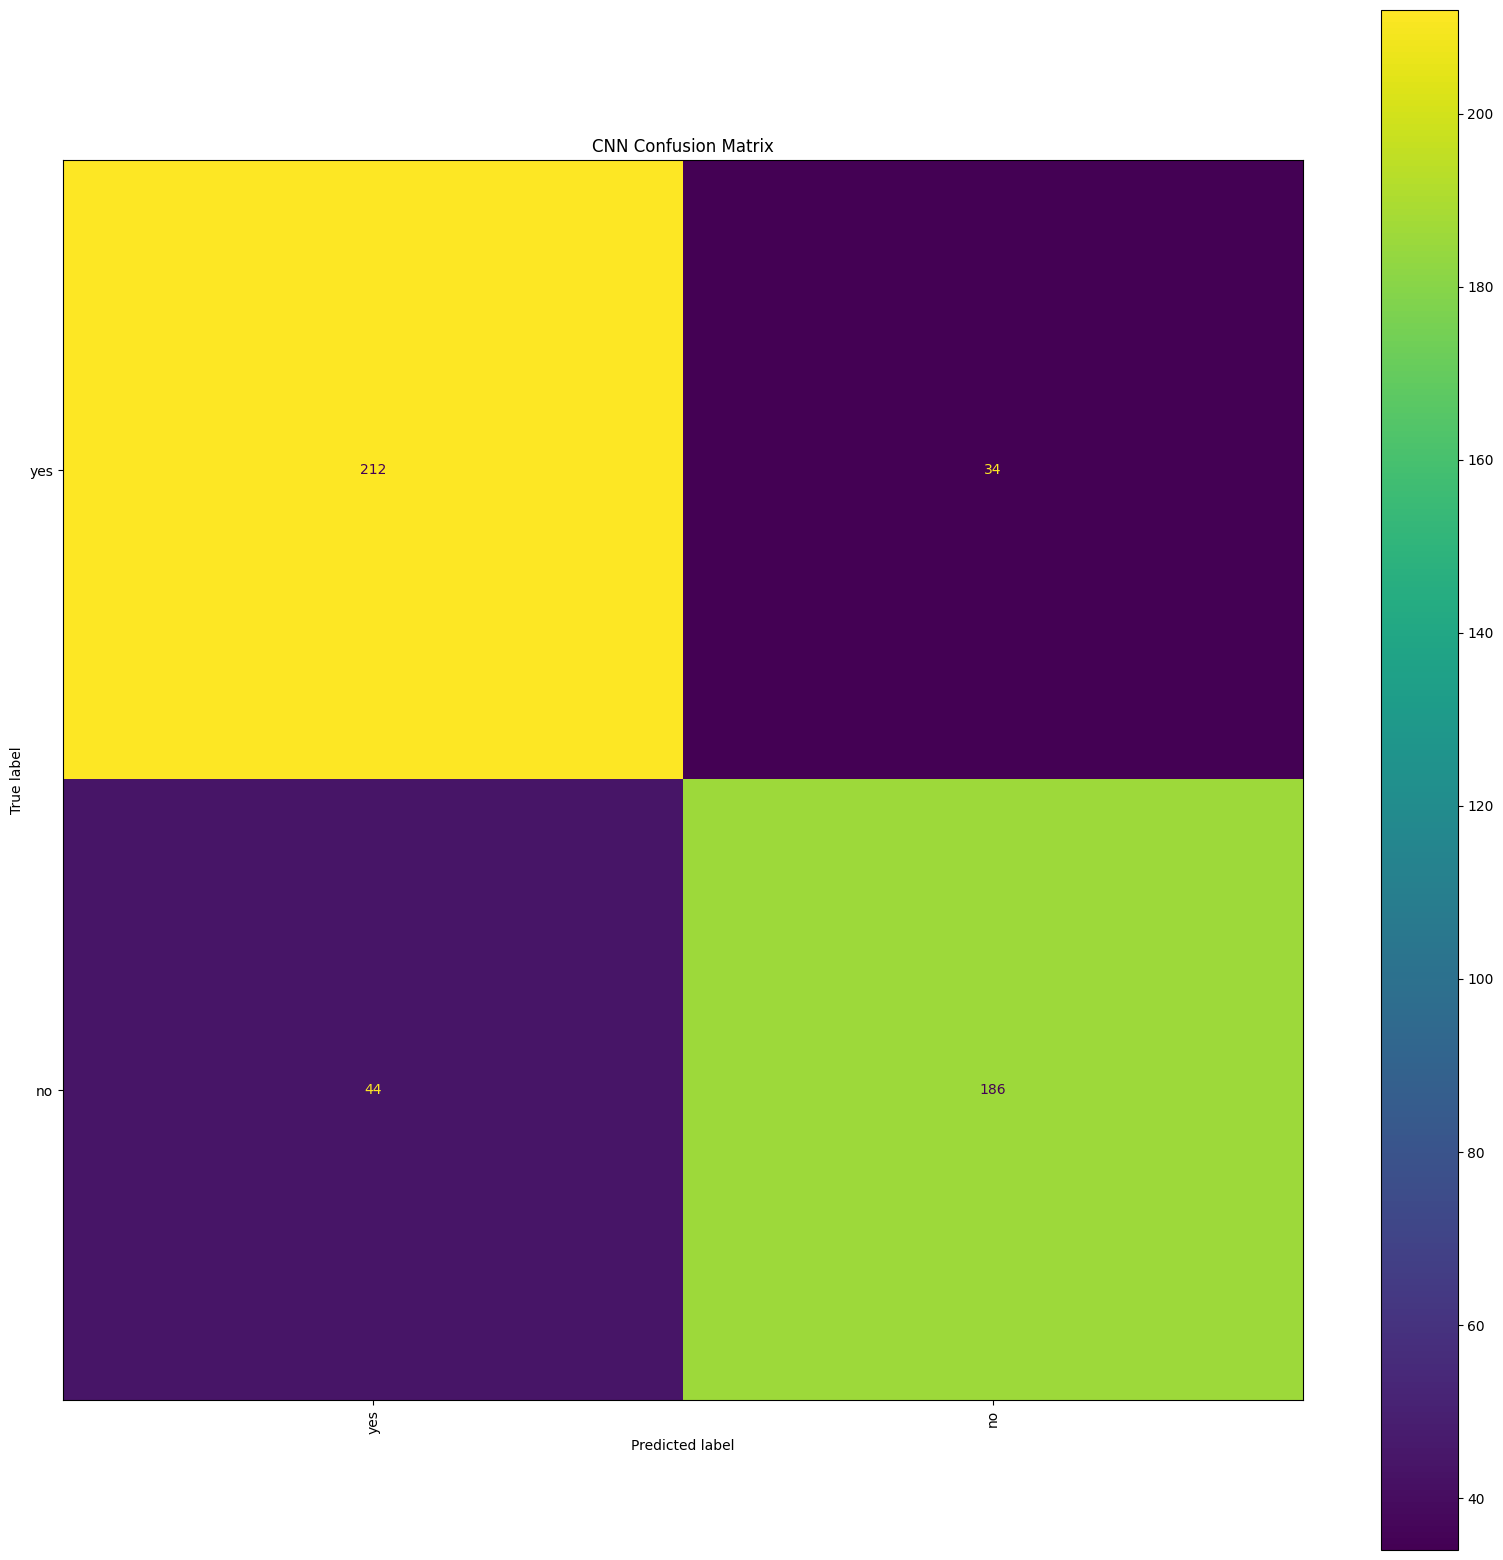

CNN Test Accuracy: 83.61%


In [18]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            # Input shape: [B, 1, 128, 32]
            nn.Conv2d(1, 32, 3, stride=2, padding=1),  # -> [B, 32, 64, 16]
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 32, 32, 8]
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # -> [B, 64, 16, 4]
            nn.ReLU(),
            nn.MaxPool2d(2),  # -> [B, 64, 8, 2]
            
            nn.Flatten(),
            nn.Linear(64 * 8 * 2, num_classes)  # Corrected input features
        )
    
    def forward(self, x):
        return self.net(x)
# Add mel-spectrogram transformation
mel_spectrogram = T.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS
)

# Create datasets with different transforms
cnn_dataset = SpeechCommandsDataset(
    root_dir="./data/train/audio/",
    classes=classes,
    transform=mel_spectrogram
)

# Split dataset
cnn_train_size = int(0.8 * len(cnn_dataset))
cnn_val_size = (len(cnn_dataset) - cnn_train_size) // 2
cnn_test_size = len(cnn_dataset) - cnn_train_size - cnn_val_size
cnn_train_dataset, cnn_val_dataset, cnn_test_dataset = random_split(cnn_dataset, [cnn_train_size, cnn_val_size, cnn_test_size])

# CNN DataLoader with proper collate_fn
def cnn_collate_fn(batch):
    spectrograms = torch.stack([item[0] for item in batch])  # [B, 1, N_MELS, TIME]
    labels = torch.tensor([item[1] for item in batch])
    return spectrograms.to(device), labels.to(device)

# Update DataLoaders
cnn_train_loader = DataLoader(cnn_train_dataset, batch_size=64, 
                            shuffle=True, collate_fn=cnn_collate_fn)
cnn_val_loader = DataLoader(cnn_val_dataset, batch_size=64, 
                           collate_fn=cnn_collate_fn)
cnn_test_loader = DataLoader(cnn_test_dataset, batch_size=64,
                            collate_fn=cnn_collate_fn)

# Initialize CNN Model
cnn_model = SimpleCNN(num_classes=len(classes)).to(device)
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Modified training/evaluation functions for CNN
def train_cnn(model, loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = outputs.argmax(dim=1)
        correct += pred.eq(target).sum().item()
        
        if batch_idx % 50 == 0:
            print(f"Epoch {epoch} | Batch {batch_idx} | Loss: {loss.item():.4f}")
    
    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"CNN Train Epoch: {epoch}\tLoss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return acc

def evaluate_cnn(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in loader:
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item()
            pred = outputs.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    
    acc = 100. * correct / len(loader.dataset)
    avg_loss = total_loss / len(loader)
    print(f"CNN Validation: Loss: {avg_loss:.4f}\tAccuracy: {acc:.2f}%")
    return acc

# Training loop for CNN
print("Training CNN Model:")
best_cnn_acc = 0
for epoch in range(1, 11):
    train_cnn(cnn_model, cnn_train_loader, cnn_optimizer, criterion, epoch)
    val_acc = evaluate_cnn(cnn_model, cnn_val_loader, criterion)
    
    if val_acc > best_cnn_acc:
        best_cnn_acc = val_acc
        torch.save(cnn_model.state_dict(), "best_cnn_model.pth")

# Evaluate CNN on test set
cnn_model.load_state_dict(torch.load("best_cnn_model.pth"))
cnn_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for data, target in cnn_test_loader:
        outputs = cnn_model(data)
        pred = outputs.argmax(dim=1)
        y_true.extend(target.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())

# CNN Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(20, 20))
disp.plot(ax=ax, xticks_rotation='vertical')
plt.title("CNN Confusion Matrix")
plt.show()

print(f"CNN Test Accuracy: {100 * np.mean(np.array(y_pred) == np.array(y_true)):.2f}%")

# To jakaś próba do usunięcia co testowane było łatwiejsze

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, Dataset
import os

# Simplified configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Tiny test dataset (2 classes, 10 samples each)
class TestDataset(Dataset):
    def __init__(self, root="data/train/audio"):
        self.classes = ['yes', 'no']  # Only 2 classes
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.samples = []
        
        # Validate directory structure
        if not os.path.exists(root):
            raise FileNotFoundError(f"Directory {root} not found!")
            
        for cls in self.classes:
            cls_dir = os.path.join(root, cls)
            if not os.path.isdir(cls_dir):
                raise FileNotFoundError(f"Class directory {cls_dir} missing!")
                
            files = [f for f in os.listdir(cls_dir)[:10]]  # First 10 files
            class_idx = self.class_to_idx[cls]
            self.samples += [(os.path.join(cls_dir, f), class_idx) for f in files]

        # Validate labels
        labels = [s[1] for s in self.samples]
        assert len(labels) > 0, "No samples found!"
        assert max(labels) < len(self.classes), f"Invalid label {max(labels)} for {len(self.classes)} classes"
        assert min(labels) >= 0, "Negative labels found!"

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        try:
            waveform, sr = torchaudio.load(self.samples[idx][0])
            
            # Ensure 1 channel
            if waveform.shape[0] > 1:
                waveform = waveform[:1, :]
                
            # Fix length to exactly 16000 samples
            if waveform.shape[1] < 16000:
                # Pad with zeros
                padding = (0, 16000 - waveform.shape[1])
                waveform = torch.nn.functional.pad(waveform, padding)
            else:
                # Trim to 16000
                waveform = waveform[:, :16000]
                
            return waveform, self.samples[idx][1]
        except Exception as e:
            print(f"Error loading {self.samples[idx][0]}: {str(e)}")
            raise

# Tiny model
class TestModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(1, 4, 3),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(4, 2)  # 2 classes
        )
        
    def forward(self, x):
        return self.net(x)

# Quick test pipeline
model = TestModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Modify the DataLoader with collate_fn
# Modified collate function
def collate_fn(batch):
    waveforms = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    
    # Stack to [batch_size, 1, 16000]
    waveforms = torch.stack(waveforms)
    labels = torch.tensor(labels)
    return waveforms.to(device), labels.to(device)

# Update DataLoader
train_loader = DataLoader(
    TestDataset(),
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn
)


# Test training loop (2 epochs)
for epoch in range(2):
    model.train()
    for batch, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        
        if batch % 2 == 0:
            print(f"Epoch {epoch+1} | Batch {batch} | Loss: {loss.item():.4f}")

# Quick validation
model.eval()
with torch.no_grad():
    test_x = torch.randn(4, 1, 16000).to(device)  # Batch of 4
    preds = model(test_x).argmax(dim=1)
    print("\nSample predictions:", preds.cpu().numpy())
    print("If you see changing losses and random predictions, it works!")

Using device: cuda
Epoch 1 | Batch 0 | Loss: 0.6965
Epoch 2 | Batch 0 | Loss: 0.7066

Sample predictions: [1 1 1 1]
If you see changing losses and random predictions, it works!
